In [3]:
import pandas as pd
import yfinance as yf

In [ ]:
# replace with your own path
path = "data/options_dataset.parquet"

df = pd.read_parquet(path)

In [12]:
spx_data = pd.read_csv("data/spx.csv", parse_dates=["date"], index_col="date")
print(spx_data.columns)

Index(['secid', 'ticker', 'index_flag', 'low', 'high', 'open', 'close',
       'volume'],
      dtype='object')


In [6]:
df["strike_price"] = df["strike_price"]/1000

In [19]:
import pandas as pd
import numpy as np

# -----------------------------------------------------------------------------
# ASSUMED PRE-LOADED DATAFRAMES
# df : options quotes/greeks with columns
#   ['optionid','ticker','date','exdate','cp_flag','strike_price',
#    'best_bid','best_offer','volume','open_interest','impl_volatility',
#    'delta','gamma','vega','theta']
# spx_data : underlying with index as dates and columns
#   ['secid','ticker','index_flag','low','high','open','close','volume']
# strike_price already scaled /1000
# -----------------------------------------------------------------------------

# 0) Basics / casting
df["date"]   = pd.to_datetime(df["date"])
df["exdate"] = pd.to_datetime(df["exdate"])
spx_data.index = pd.to_datetime(spx_data.index)

# convenience mid price
df["mid"] = (df["best_bid"] + df["best_offer"]) / 2

# 1) Backtest parameters (change as you like)
ticker0     = "SPX"
start_date  = pd.Timestamp("2020-01-01")
m0_list     = [1.00]           # you can loop over several moneyness values if desired
target_days = 21               # ~1 trading month
min_days, max_days = 14, 35

# 2) Trading calendar align (first common trade date on/after start)
opt_dates = df.loc[df["ticker"] == ticker0, "date"].drop_duplicates()
common_dates = pd.Index(opt_dates)[pd.Index(opt_dates) >= start_date].intersection(spx_data.index[spx_data.index >= start_date])
trade_date = common_dates.min()

# 3) Storage for backtest path
rows = []

# 4) Month-by-month loop (non-overlapping)
current_date = trade_date
m0_idx = 0

while True:
    m0 = m0_list[m0_idx % len(m0_list)]
    S0 = float(spx_data.loc[current_date, "close"])

    # — Select 1M expiry for entry day
    univ = df[(df["ticker"] == ticker0) & (df["date"] == current_date)].copy()
    univ["dte"] = (univ["exdate"] - current_date).dt.days
    cands = univ[(univ["dte"] >= min_days) & (univ["dte"] <= max_days)]
    if cands.empty:
        break  # out of data

    ex_pick = cands.loc[(cands["dte"] - target_days).abs().idxmin(), "exdate"]
    K_target = m0 * S0
    slice_exp = cands[cands["exdate"] == ex_pick].copy()
    strike_pick = slice_exp.loc[(slice_exp["strike_price"] - K_target).abs().idxmin(), "strike_price"]

    # — Identify the exact call/put optionids for the straddle
    call_row0 = slice_exp[(slice_exp["strike_price"] == strike_pick) & (slice_exp["cp_flag"].str.upper() == "C")].iloc[0]
    put_row0  = slice_exp[(slice_exp["strike_price"] == strike_pick) & (slice_exp["cp_flag"].str.upper() == "P")].iloc[0]
    call_id, put_id = call_row0["optionid"], put_row0["optionid"]

    # — Enter straddle at offers (long 1C + 1P)
    entry_call_offer = float(call_row0["best_offer"])
    entry_put_offer  = float(put_row0["best_offer"])
    straddle_qty_call = 1.0
    straddle_qty_put  = 1.0
    straddle_cash = -(entry_call_offer * straddle_qty_call + entry_put_offer * straddle_qty_put)  # cash outflow on entry

    # — Initialize hedge positions (start flat)
    phi_opt = 0.0   # hedge option quantity
    phi_und = 0.0   # underlying quantity
    hedge_opt_id = None

    # — Iterate daily from entry date to expiry date (inclusive)
    period_dates = common_dates[(common_dates >= current_date) & (common_dates <= ex_pick)]

    # carry forward MTM values
    prev_value_total = None

    for d in period_dates:
        S = float(spx_data.loc[d, "close"])

        # slice today’s option quotes for this expiry
        # --- inside your for d in period_dates loop ---

        today = df[(df["ticker"] == ticker0) & (df["date"] == d) & (df["exdate"] == ex_pick)].copy()
        if today.empty:
            continue  # skip days with no option data

        # find today's call/put rows
        call_today = today[today["optionid"] == call_id]
        put_today  = today[today["optionid"] == put_id]
        if call_today.empty or put_today.empty:
            continue  # skip if either leg missing that day

        call_today = call_today.iloc[0]
        put_today  = put_today.iloc[0]
        V_call_mid = float(call_today["mid"])
        V_put_mid  = float(put_today["mid"])
        V_value    = straddle_qty_call * V_call_mid + straddle_qty_put * V_put_mid

        # target portfolio Greeks (today)
        Delta_V = float(call_today["delta"] + put_today["delta"]) * 1.0   # qty 1 each
        Gamma_V = float(call_today["gamma"] + put_today["gamma"]) * 1.0

        # choose hedge option (max |gamma| within same expiry; near-ATM bias)
        today["moneyness"] = today["strike_price"] / S

        # prefer near-ATM window; fallback to full set if empty
        pick_space = today[(today["moneyness"] > 0.8) & (today["moneyness"] < 1.2)]
        if pick_space.empty:
            pick_space = today

        # keep rows with a usable mid price
        pick_space = pick_space.copy()
        pick_space["mid"] = (pick_space["best_bid"] + pick_space["best_offer"]) / 2
        pick_space = pick_space[np.isfinite(pick_space["mid"])]

        # 1) primary: max |gamma| among finite gamma
        gmask = np.isfinite(pick_space["gamma"])
        if gmask.any():
            idx = (pick_space.loc[gmask, "gamma"].abs()).idxmax()
            hedge_row = pick_space.loc[idx]
        else:
            # 2) fallback: nearest ATM by |strike - S| among rows with mid
            if pick_space.empty:
                # 3) last resort: skip the day if nothing usable
                continue
            idx = (pick_space["strike_price"] - S).abs().idxmin()
            hedge_row = pick_space.loc[idx]

        hedge_opt_id = hedge_row["optionid"]
        Delta_H = float(hedge_row["delta"]) if np.isfinite(hedge_row["delta"]) else 0.0
        Gamma_H = float(hedge_row["gamma"]) if np.isfinite(hedge_row["gamma"]) else 1e-8  # tiny to avoid blow-up
        H_mid   = float(hedge_row["mid"])

        # hedge option Greeks & mid price
        Delta_H = float(hedge_row["delta"])
        Gamma_H = float(hedge_row["gamma"])
        H_mid   = float(hedge_row["mid"])

        # underlying greeks
        Delta_U = 1.0

        # compute desired hedge sizes for delta-gamma neutral
        # phi_option = Gamma_V / Gamma_H ; phi_underlying = Delta_V - phi_option * Delta_H
        eps = 1e-8
        phi_opt_des = Gamma_V / (Gamma_H if abs(Gamma_H) > eps else np.sign(Gamma_H) * eps or eps)
        phi_und_des = Delta_V - phi_opt_des * Delta_H

        # (Re)balance hedge positions to desired sizes (we allow fractional; no trading costs here)
        phi_opt = phi_opt_des
        phi_und = phi_und_des

        # mark hedge portfolio at mid
        H_value = phi_opt * H_mid
        U_value = phi_und * S

        # total portfolio value (target straddle + hedges + initial entry cash)
        total_value = V_value - H_value - U_value + straddle_cash

        # daily unrealized PnL (change in total value)
        if prev_value_total is None:
            daily_pnl = 0.0
        else:
            daily_pnl = total_value - prev_value_total

        # tracking error here is simply the combined hedged-book PnL (should hover ~0 if hedge is effective)
        tracking_error = daily_pnl

        # residual greeks after hedge (sanity)
        Delta_after = Delta_V - phi_opt * Delta_H - phi_und * Delta_U
        Gamma_after = Gamma_V - phi_opt * Gamma_H

        rows.append({
            "date": d,
            "period_start": current_date,
            "expiry": ex_pick,
            "S": S,
            "call_id": call_id, "put_id": put_id, "hedge_id": hedge_opt_id,
            "K_straddle": float(strike_pick),
            "V_value": V_value,
            "H_value": H_value,
            "U_value": U_value,
            "total_value": total_value,
            "daily_pnl": daily_pnl,
            "tracking_error": tracking_error,
            "Delta_V": Delta_V, "Gamma_V": Gamma_V,
            "Delta_H": Delta_H, "Gamma_H": Gamma_H,
            "phi_opt": phi_opt, "phi_und": phi_und,
            "Delta_after": Delta_after, "Gamma_after": Gamma_after
        })
        prev_value_total = total_value

    # advance to the day **after** expiry for next non-overlapping month
    next_candidates = common_dates[common_dates > ex_pick]
    if len(next_candidates) == 0:
        break
    current_date = next_candidates.min()
    m0_idx += 1

# 5) Results DataFrame
bt = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

# 6) Some quick summaries
bt["cum_pnl"] = bt.groupby("period_start")["daily_pnl"].cumsum()
overall_pnl = bt["daily_pnl"].sum()
mean_abs_te = bt["tracking_error"].abs().mean()

print("=== Backtest summary ===")
print(f"Periods run     : {bt['period_start'].nunique()}")
print(f"Total days      : {len(bt):,}")
print(f"Overall PnL     : {overall_pnl:,.2f}")
print(f"Mean |Tracking Error| per day : {mean_abs_te:,.6f}")

# peek
bt.head(10)

=== Backtest summary ===
Periods run     : 61
Total days      : 916
Overall PnL     : -86,196.34
Mean |Tracking Error| per day : 2,579.581041


,date,period_start,expiry,S,call_id,put_id,hedge_id,K_straddle,V_value,H_value,...,tracking_error,Delta_V,Gamma_V,Delta_H,Gamma_H,phi_opt,phi_und,Delta_after,Gamma_after,cum_pnl
0,2020-01-02,2020-01-02,2020-01-22,3257.85,131695004,131695120,131695007,3260.0,53.80,33.591331,...,0.000000,-0.010552,0.011823,0.398960,0.006177,1.914036,-0.774176,0.0,0.0,0.000000
1,2020-01-03,2020-01-02,2020-01-22,3234.85,131695004,131695120,131695120,3260.0,60.00,82.207511,...,-5795.879690,-0.236395,0.010666,-0.618346,0.005339,1.997752,0.998907,0.0,0.0,-5795.879690
2,2020-01-06,2020-01-02,2020-01-22,3246.28,131695004,131695120,131695005,3260.0,52.65,33.768322,...,6267.296458,-0.149245,0.012125,0.391601,0.006140,1.974756,-0.922561,0.0,0.0,471.416768
3,2020-01-07,2020-01-02,2020-01-22,3237.18,131695004,131695120,131695003,3260.0,50.70,33.619857,...,436.987053,-0.272630,0.012601,0.397319,0.006353,1.983472,-1.060701,0.0,0.0,908.403821
4,2020-01-08,2020-01-02,2020-01-22,3253.05,131695004,131695120,131695006,3260.0,50.20,32.651663,...,-681.263526,-0.066019,0.012697,0.398908,0.006494,1.955189,-0.845960,0.0,0.0,227.140295
5,2020-01-09,2020-01-02,2020-01-22,3274.70,131695004,131695120,131717085,3260.0,47.25,27.176357,...,-1068.477373,0.225486,0.013391,0.430888,0.007810,1.714597,-0.513313,0.0,0.0,-841.337079
6,2020-01-10,2020-01-02,2020-01-22,3265.35,131695004,131695120,131695007,3260.0,42.30,28.864291,...,599.021601,0.107129,0.015015,0.434965,0.008089,1.856225,-0.700264,0.0,0.0,-242.315478
7,2020-01-13,2020-01-02,2020-01-22,3288.13,131695004,131695120,131717086,3260.0,44.65,17.496978,...,-1806.604871,0.462606,0.013848,0.440435,0.010091,1.372312,-0.141808,0.0,0.0,-2048.920349
8,2020-01-14,2020-01-02,2020-01-22,3283.15,131695004,131695120,131695009,3260.0,41.25,18.570260,...,358.930003,0.397672,0.015159,0.436034,0.010163,1.491587,-0.252711,0.0,0.0,-1689.990346
9,2020-01-15,2020-01-02,2020-01-22,3289.29,131695004,131695120,131717086,3260.0,41.05,13.192898,...,-819.540843,0.540337,0.014765,0.441515,0.012031,1.227246,-0.001511,0.0,0.0,-2509.531189


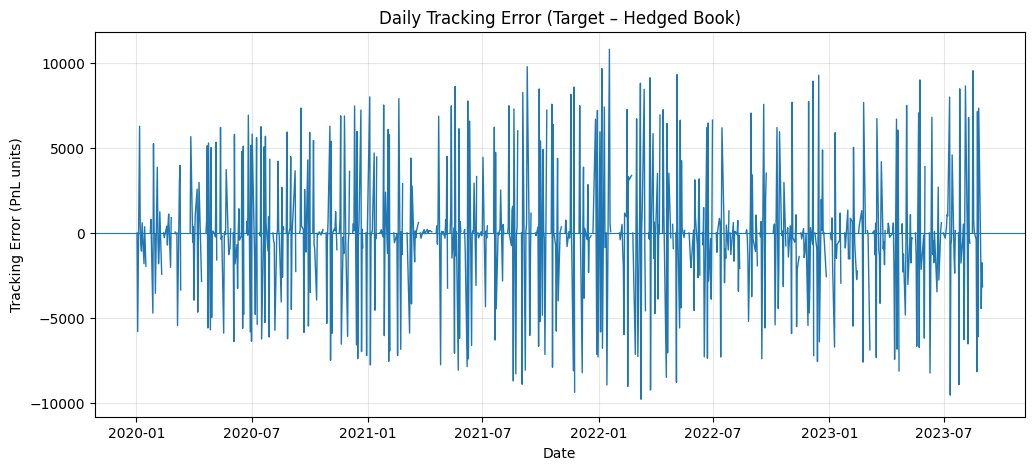

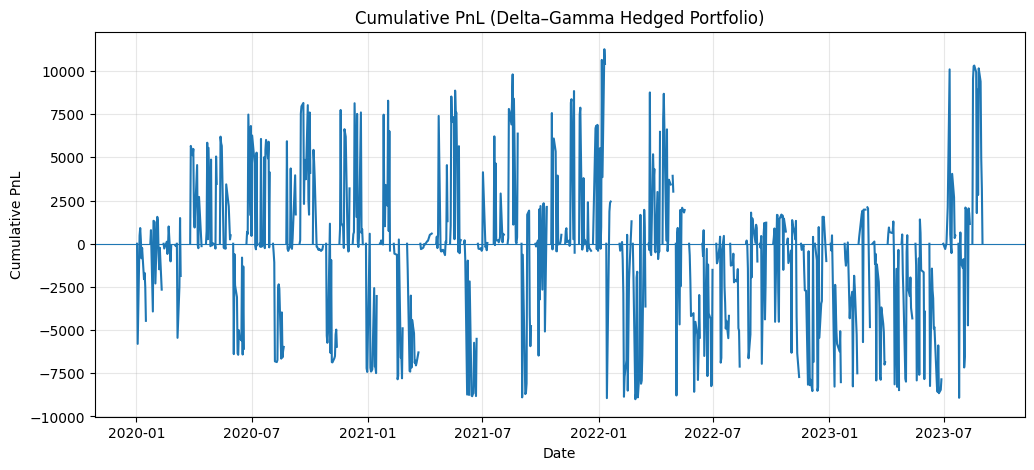

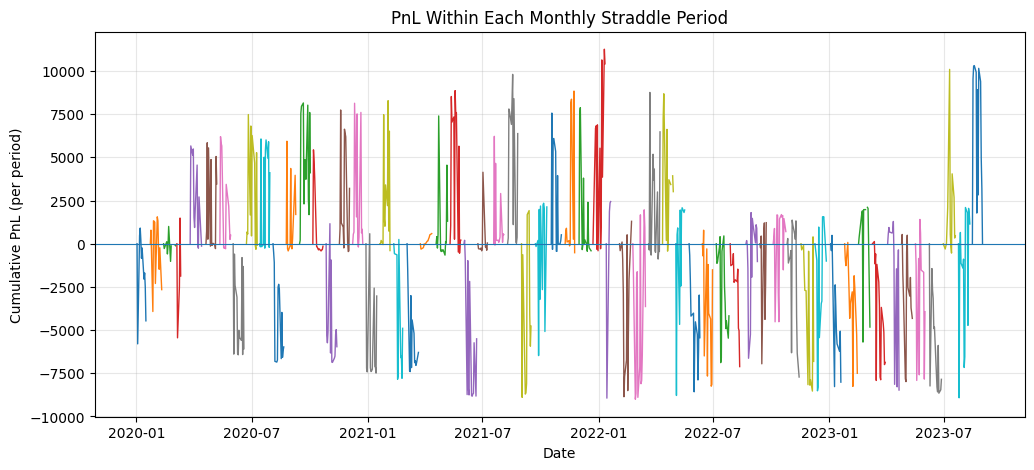

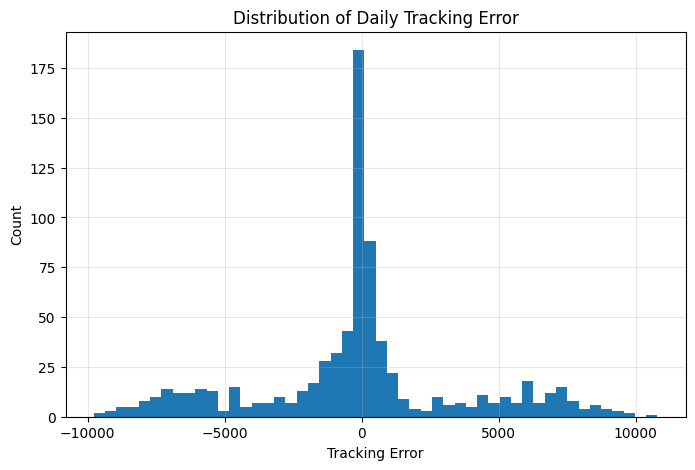

In [20]:
import matplotlib.pyplot as plt

# If you haven't created it yet:
bt = bt.sort_values("date").reset_index(drop=True)
if "cum_pnl" not in bt.columns:
    bt["cum_pnl"] = bt["daily_pnl"].cumsum()

# 1) Daily tracking error
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["tracking_error"], lw=1)
plt.axhline(0, lw=0.8)
plt.title("Daily Tracking Error (Target – Hedged Book)")
plt.xlabel("Date"); plt.ylabel("Tracking Error (PnL units)")
plt.grid(True, alpha=0.3)
plt.show()

# 2) Cumulative PnL over the whole backtest
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["cum_pnl"], lw=1.5)
plt.axhline(0, lw=0.8)
plt.title("Cumulative PnL (Delta–Gamma Hedged Portfolio)")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
plt.grid(True, alpha=0.3)
plt.show()

# 3) Cumulative PnL reset each 1-month period (non-overlapping)
plt.figure(figsize=(12,5))
for period, sub in bt.groupby("period_start", sort=True):
    sub = sub.sort_values("date").copy()
    sub["cum_pnl_period"] = sub["daily_pnl"].cumsum()
    plt.plot(sub["date"], sub["cum_pnl_period"], lw=1)
plt.axhline(0, lw=0.8)
plt.title("PnL Within Each Monthly Straddle Period")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL (per period)")
plt.grid(True, alpha=0.3)
plt.show()

# 4) (Optional) Histogram of tracking error
plt.figure(figsize=(8,5))
plt.hist(bt["tracking_error"].dropna(), bins=50)
plt.title("Distribution of Daily Tracking Error")
plt.xlabel("Tracking Error"); plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

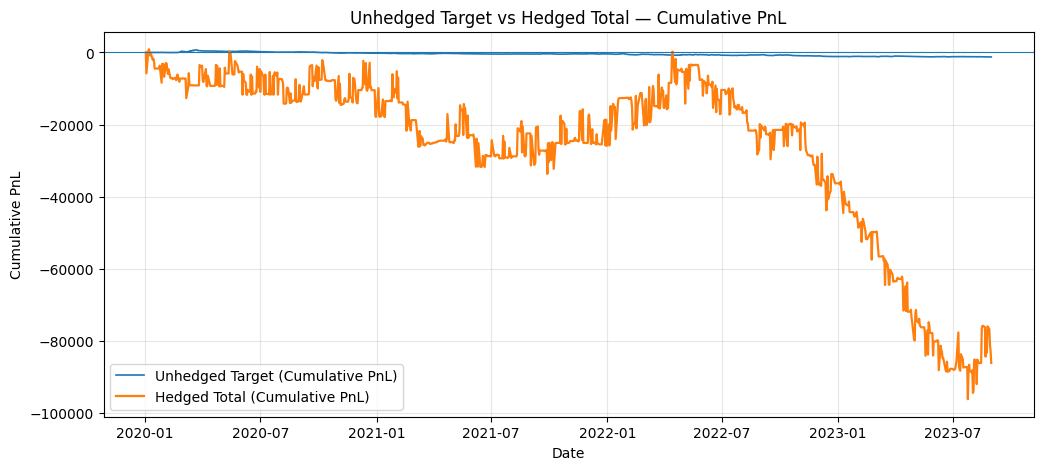

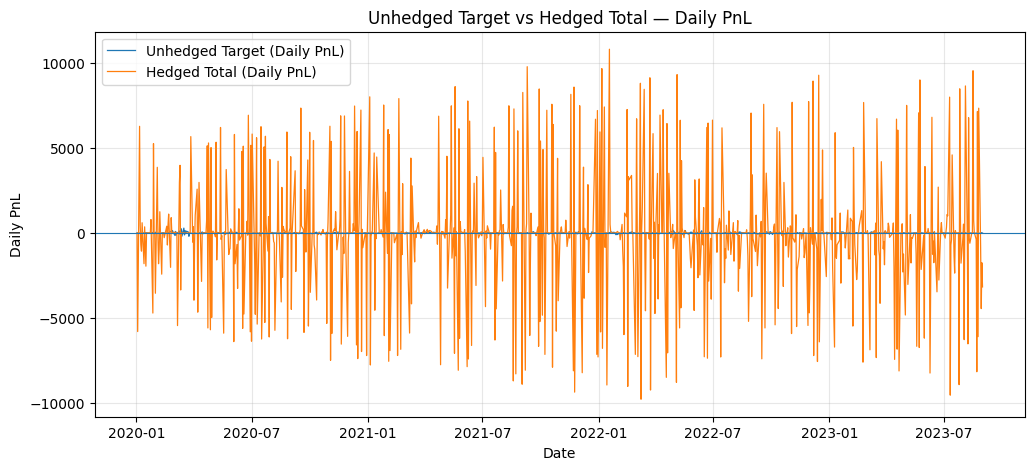

In [21]:
import matplotlib.pyplot as plt

# Ensure chronological order
bt = bt.sort_values("date").reset_index(drop=True)

# Unhedged target PnL: day-over-day change in the straddle's marked value
bt["unhedged_daily_pnl"] = bt.groupby("period_start")["V_value"].diff().fillna(0.0)

# Hedged PnL is already your daily_pnl from the combined book
bt["hedged_daily_pnl"] = bt["daily_pnl"].fillna(0.0)

# Cumulative PnL (overall; both start from 0 at the very beginning)
bt["unhedged_cum_pnl"] = bt["unhedged_daily_pnl"].cumsum()
bt["hedged_cum_pnl"]   = bt["hedged_daily_pnl"].cumsum()

# ---- Overlay: cumulative PnL (unhedged vs hedged) ----
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["unhedged_cum_pnl"], label="Unhedged Target (Cumulative PnL)", lw=1.2)
plt.plot(bt["date"], bt["hedged_cum_pnl"],   label="Hedged Total (Cumulative PnL)", lw=1.6)
plt.axhline(0, lw=0.8)
plt.title("Unhedged Target vs Hedged Total — Cumulative PnL")
plt.xlabel("Date"); plt.ylabel("Cumulative PnL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- (Optional) Overlay: daily PnL time series ----
plt.figure(figsize=(12,5))
plt.plot(bt["date"], bt["unhedged_daily_pnl"], label="Unhedged Target (Daily PnL)", lw=0.9)
plt.plot(bt["date"], bt["hedged_daily_pnl"],   label="Hedged Total (Daily PnL)", lw=0.9)
plt.axhline(0, lw=0.8)
plt.title("Unhedged Target vs Hedged Total — Daily PnL")
plt.xlabel("Date"); plt.ylabel("Daily PnL")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()